### Model

In [1]:
import libs.forward_lib.forward_model as fm
import libs.read_data as rd
import libs.visualizer as vs
import torch
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# Parameter Definition
NA = 1.2
Rindex= 1.5
lambda_= 532.0/ 1000 #um
dx, dy, dz= 1/3,1/3,1. #um
ep_dx, ep_dy =2,2
Nx,Ny,Nz = 30,30,10
m = 10
down_factor = 1
num_planes = 1

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz,dx,dy,dz)

# fm.load_model(m = m, down_factor=down_factor, diff_pattern=0)
# fm.init_one_shot(m, down_factor=down_factor,num_planes=num_planes,save_mat=True,diff_pattern=2, pattern_type='random_choice')

def one_shot_model(X):
    return torch.matmul(fm.A,X)

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


***Results***

In [51]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np


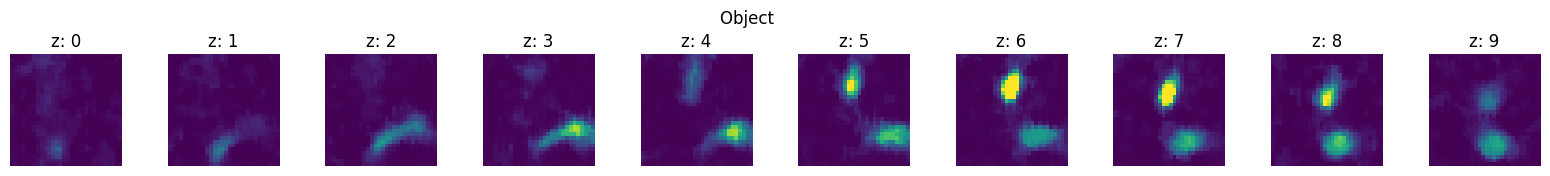

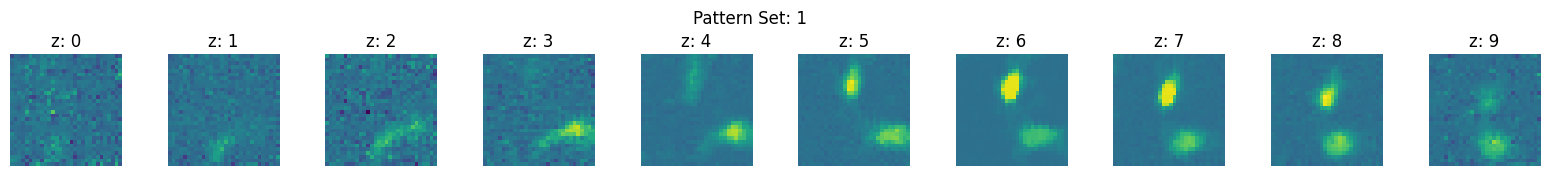

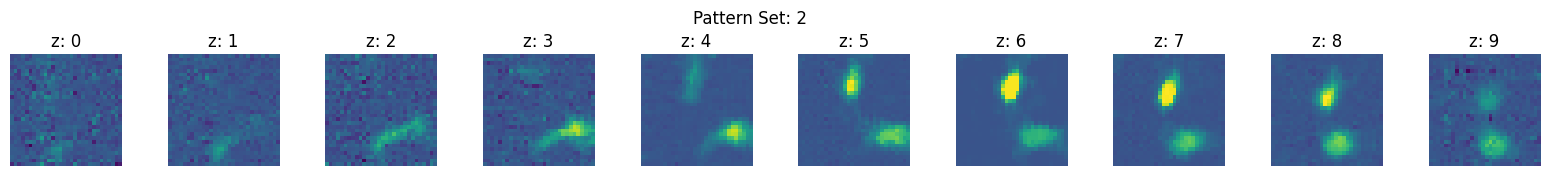

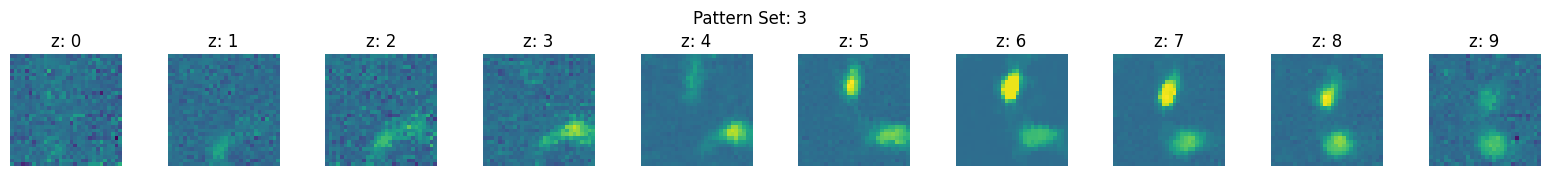

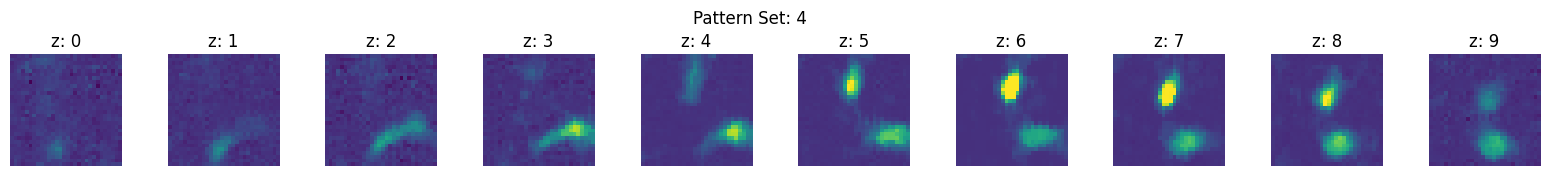

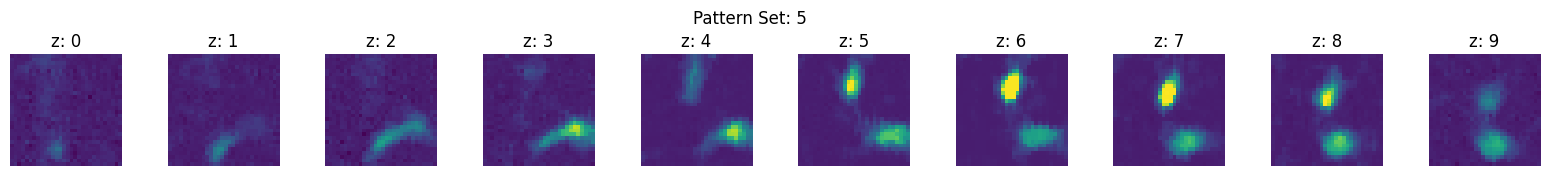

In [67]:

# rd.load_object("blood_cell", verbose=False)
X_original = (rd.X).flatten()
X3D_orig = X_original.view(Nz,Nx,Ny)
ssim_list, psnr_list = [], []
vs.show_planes_z(X3D_orig.detach().cpu().numpy(),f"Object ",[i for i in range(Nz)])
for pattern in range(5):
    fm.load_model(m = m, down_factor=down_factor, diff_pattern=pattern, num_planes=num_planes, pattern_type='random_choice')
    Y = one_shot_model(X_original)
    X_reconstructed = torch.linalg.lstsq(fm.A,Y).solution   
    X3D_recons = X_reconstructed.view(Nz,Nx, Ny)
    vs.show_planes_z(X3D_recons.detach().cpu().numpy(),f"Pattern Set: {pattern+1}",[i for i in range(Nz)])
    
    ssim_values, psnr_values = [], []
    for nz in range(Nz):
        plane_X = rd.X[0][nz].detach().cpu().numpy()
        plane_xhat = X3D_recons[nz].detach().cpu().numpy()

        ssim_plane = ssim(plane_X, plane_xhat, data_range=np.max(plane_xhat)-np.min(plane_xhat))
        ssim_values.append(ssim_plane) 

        psnr_plane = psnr(plane_X, plane_xhat, data_range=np.max(plane_xhat)-np.min(plane_xhat))
        psnr_values.append(psnr_plane)
    ssim_list.append(ssim_values), psnr_list.append(psnr_values)

In [98]:
print(" -----------------------------------------------------")
print("|Patterns | Set 01 | Set 02 | Set 03 | Set 04 |Set 05 | ")
print(" -----------------------------------------------------")
for i in range(Nz):
    print("|plane {}  | {:.4f} |{:.4f}  |{:.4f}  |{:.4f}  |{:.4f} | ".format(i, ssim_list[0][i],ssim_list[1][i], ssim_list[2][i], ssim_list[3][i],ssim_list[4][i] ))
print(" -----------------------------------------------------")

 -----------------------------------------------------
|Patterns | Set 01 | Set 02 | Set 03 | Set 04 |Set 05 | 
 -----------------------------------------------------
|plane 0  | 0.1518 |0.1837  |0.1429  |0.5220  |0.6458 | 
|plane 1  | 0.2819 |0.3225  |0.2333  |0.7241  |0.8289 | 
|plane 2  | 0.3156 |0.3620  |0.2835  |0.6403  |0.7678 | 
|plane 3  | 0.4684 |0.5062  |0.4378  |0.8381  |0.9065 | 
|plane 4  | 0.8103 |0.8883  |0.8091  |0.9759  |0.9876 | 
|plane 5  | 0.8709 |0.8861  |0.8685  |0.9811  |0.9921 | 
|plane 6  | 0.9994 |0.9995  |0.9993  |0.9999  |1.0000 | 
|plane 7  | 0.9254 |0.9221  |0.9135  |0.9920  |0.9950 | 
|plane 8  | 0.8620 |0.8664  |0.8202  |0.9839  |0.9897 | 
|plane 9  | 0.5523 |0.5866  |0.5346  |0.8299  |0.9078 | 
 -----------------------------------------------------


In [4]:
ATA = (fm.A.T@fm.A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")